(01-nonlinear-decision-boundary)=
# Nonlinear decision boundary

Going back to classification. Let us generate data that is **not** linearly separable. 
In this section, we will show that linear classification extends to input data that is not linearly separable.
The idea is to apply a sequence of transformations on the input such that the final result becomes linearly separable.

In [1]:
import torch 
torch.manual_seed(2)

N = 1500  # sample size
noise = lambda e: torch.randn(N, 2) * e
t = 2 * torch.pi * torch.rand(N, 1)
s = 2 * torch.pi * torch.rand(N, 1)

x0 = torch.cat([0.1 * torch.cos(s), 0.1 * torch.sin(s)], dim=1) + noise(0.05)
x1 = torch.cat([1.0 * torch.cos(t), 1.0 * torch.sin(t)], dim=1) + noise(0.1)
y0 = (torch.ones(N,) * 0).long()
y1 = (torch.ones(N,) * 1).long()

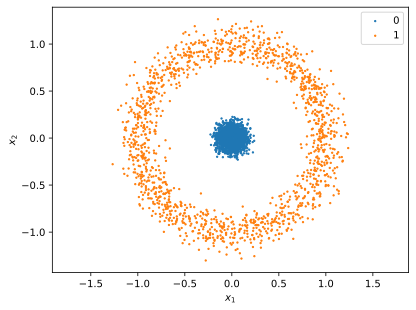

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.scatter(x0[:, 0], x0[:, 1], s=2.0, label=0, color="C0")
plt.scatter(x1[:, 0], x1[:, 1], s=2.0, label=1, color="C1")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.axis('equal');

Modeling this with a fully-connected neural network with one hidden layer containing units that uses the [tanh function](https://mathworld.wolfram.com/HyperbolicTangent.html) as activation: $\text{tanh}(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}.$
This maps $\mathbb{R}$ to $[-1, 1]$ symmetrically with $\text{tanh}(0) = 0$ and $\text{tanh}(z) \to \pm 1$ as $z \to \pm\infty.$ Note that tanh is actually just a scaled and translated version of the sigmoid function.

In [3]:
import torch.nn as nn
from torchsummary import summary

model = lambda: nn.Sequential(
    nn.Linear(2, 3), nn.Tanh(),
    nn.Linear(3, 2)
)

summary(model(), input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              Tanh-2                    [-1, 3]               0
            Linear-3                    [-1, 2]               8
Total params: 17
Trainable params: 17
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Gradient descent on [**cross-entropy loss**](https://en.wikipedia.org/wiki/Cross-entropy) (equivalent to NLL):

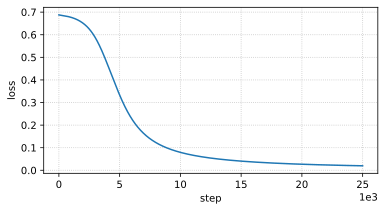

In [4]:
import torch.nn.functional as F

net = model()
optim = torch.optim.SGD(net.parameters(), lr=0.01)

x = torch.cat([x0, x1])
y = torch.cat([y0, y1])
history = []
for step in range(25000):
    s = net(x)
    loss = F.cross_entropy(s, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    history.append(loss.item())

plt.figure(figsize=(6, 3))
plt.plot(history)
plt.xlabel("step")
plt.grid(linestyle="dotted", alpha=0.8)
plt.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
plt.ylabel("loss");

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# transformations
linear_0 = net[0](x0).detach().numpy()
linear_1 = net[0](x1).detach().numpy()
linear_relu_0 = net[1](net[0](x0)).detach().numpy()
linear_relu_1 = net[1](net[0](x1)).detach().numpy()

# separating hyperplane (see above discussion, i.e. w <- w1 - w0  == logistic reg)
h = 1
w, b = net[2].parameters()
w, b = (w[h] - w[h-1]).detach().numpy(), (b[h] - b[h-1]).detach().numpy()

# plot
fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')

ax0.grid(alpha=0.8, linestyle="dotted")
ax0.set_axisbelow(True)
ax0.scatter(x0[:, 0], x0[:, 1], s=2.0, label=0, color="C0")
ax0.scatter(x1[:, 0], x1[:, 1], s=2.0, label=1, color="C1")
ax0.set_xlabel("$x_1$")
ax0.set_ylabel("$x_2$")
ax0.set_xlim(-1.5, 1.5)
ax0.set_ylim(-1.5, 1.5)
ax0.set_title("(a) input")
ax0.legend()
ax0.axis('equal')

ax1.scatter(linear_0[:, 0], linear_0[:, 1], linear_0[:, 2], s=3, label=0, color="C0")
ax1.scatter(linear_1[:, 0], linear_1[:, 1], linear_1[:, 2], s=3, label=1, color="C1")
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$x_3$')
ax1.set_title('(b) linear')

ax2.scatter(linear_relu_0[:, 0], linear_relu_0[:, 1], linear_relu_0[:, 2], s=3, label=0, color="C0")
ax2.scatter(linear_relu_1[:, 0], linear_relu_1[:, 1], linear_relu_1[:, 2], s=3, label=1, color="C1")
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$x_3$')
ax2.set_title('(c) linear + tanh')

# Generate grid of points
x_min = min(linear_relu_1[:, 0].min(), linear_relu_0[:, 0].min())
x_max = max(linear_relu_1[:, 0].max(), linear_relu_0[:, 0].max())
y_min = min(linear_relu_1[:, 1].min(), linear_relu_0[:, 1].min())
y_max = max(linear_relu_1[:, 1].max(), linear_relu_0[:, 1].max())
a, b, c, d = w[0], w[1], w[2], b
x = np.linspace(x_min, x_max, 50)
y = np.linspace(y_min, y_max, 50)
X, Y = np.meshgrid(x, y)
Z = (-a * X - b * Y - d) / c

# Plot the hyperplane for the positive class
ax2.plot_surface(X, Y, Z, alpha=0.5, color=f"C{h}")
fig.tight_layout();

Checking classification accuracy:

In [6]:
a = (torch.argmax(net(x0), dim=1) == y0).float().mean().item()
b = (torch.argmax(net(x1), dim=1) == y1).float().mean().item()
a, b

(1.0, 1.0)

Decision boundary in the input space. Note that we have to convert logits to probabilities:

In [7]:
def prediction(x, y):
    p = F.softmax(net(torch.tensor([[x, y]])), dim=1)
    return p[0, 1].item()

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Define your custom colormap
colors = ["C0", "C1"]
n_bins = 100
cm = LinearSegmentedColormap.from_list(name="", colors=colors, N=n_bins)

# Create a grid of points
N = 100
x = np.linspace(-1.5, 1.5, N)
y = np.linspace(-1.5, 1.5, N)
X, Y = np.meshgrid(x, y)

# Calculate function values for each point on the grid
Z = np.zeros_like(X)
for i in range(N):
    for j in range(N):
        Z[i, j] = prediction(float(X[i, j]), float(Y[i, j]))

# Create a color plot using the custom colormap
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black")
plt.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.axis('equal');

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show();

Fig. *Probability assigned by the trained network on the input space. Note that we were able to extend linear classification to learning a nonlinear decision boundary. Using ReLU activation here instead of Tanh results in a boundary with sharp corners. This can be thought of as a manifestation of inductive bias.*

<br>

**Remark.** Cross entropy is defined as $H(p, \hat{p}) = -\mathbb{E}_{p}[\log \hat{p}]$ where $p$ is the true probability and $\hat{p}$ is the modeled probabilities. This is equivalent to NLL when $p$ are one-hot probability vectors, i.e. we calculate the average $-\log \hat{p}_y$ where $y$ is the target class. Thus, any classification model trained with cross-entropy on hard labels maximizes the likelihood of the training dataset.

In practice, we convert class scores into probabilities using the softmax function. The PyTorch implementation [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) reflects this. The true probability vector $p$ can be of shape $(B,)$ where $B$ is the number of inputs where $p_i = 0, 1, \ldots, K-1$ for $K$ classes (hard labels), or $(B, K)$ where $p_{ij} \in [0, 1]$ containing probabilities for class $j$ (soft labels).

In [9]:
import torch
import torch.nn.functional as F

B = 32                               # num examples
K = 3                                # num classes
s = torch.randn(B, K)                # logits (class scores)
p = torch.randint(0, K, size=(B,))   # hard labels => one-hot true probas
F.cross_entropy(s, target=p)         # expects logits (!)

tensor(1.3839)

`F.cross_entropy` calculates cross-entropy with softmax probas:

In [10]:
q = F.softmax(s, dim=1)
-torch.log(q[range(B), p]).mean()

tensor(1.3839)